<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Natural%20Language%20Processing%20(NLP)/Custom_PyTorch_Text_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [7]:
df_train, df_test = train_test_split(df, test_size=0.33)
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [8]:
idx = 1
word2idx = {'<PAD>': 0}

In [9]:
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split() #simple tokenization
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [10]:
word2idx

{'<PAD>': 0,
 'i': 1,
 'tagged': 2,
 'my': 3,
 'friends': 4,
 'that': 5,
 'you': 6,
 'seemed': 7,
 'to': 8,
 'count': 9,
 'as': 10,
 'your': 11,
 'friends.': 12,
 'shall': 13,
 'come': 14,
 'get': 15,
 'pickle': 16,
 'what': 17,
 'need.': 18,
 'have': 19,
 'a': 20,
 'person': 21,
 'give': 22,
 'na.': 23,
 'free': 24,
 'for': 25,
 '1st': 26,
 'week!': 27,
 'no1': 28,
 'nokia': 29,
 'tone': 30,
 '4': 31,
 'ur': 32,
 'mob': 33,
 'every': 34,
 'week': 35,
 'just': 36,
 'txt': 37,
 '8007': 38,
 'txting': 39,
 'and': 40,
 'tell': 41,
 'mates': 42,
 'www.getzed.co.uk': 43,
 'pobox': 44,
 '36504': 45,
 'w45wq': 46,
 'norm150p/tone': 47,
 '16+': 48,
 'yes': 49,
 'but': 50,
 'can': 51,
 'we': 52,
 'meet': 53,
 'in': 54,
 'town': 55,
 'cos': 56,
 'will': 57,
 'go': 58,
 'gep': 59,
 'then': 60,
 'home.': 61,
 'could': 62,
 'text': 63,
 'at': 64,
 'bus': 65,
 'stop.': 66,
 "don't": 67,
 'worry': 68,
 "we'll": 69,
 'finished': 70,
 'by': 71,
 'march': 72,
 '\x89û_': 73,
 'ish!': 74,
 'did': 75,
 'tr

In [11]:
word2idx.__len__()

10674

In [12]:
train_sentences_as_int = []
for i, row in df_train.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens]
    train_sentences_as_int.append(sentence_as_int)

test_sentences_as_int = []
for i, row in df_test.iterrows():
    tokens = row['data'].lower().split()
    sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
    test_sentences_as_int.append(sentence_as_int)

In [13]:
train_sentences_as_int.__len__(), test_sentences_as_int.__len__()

(3733, 1839)

In [14]:
def data_generator(X, y, batch_size=32):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(y.__len__() / batch_size))
    for i in range(n_batches):
        end = min((i+1) * batch_size, y.__len__())

        X_batch = X[i * batch_size:end]
        y_batch = y[i * batch_size:end]

        max_len = np.max([x.__len__() for x in X_batch])
        for j in range(X_batch.__len__()):
            x = X_batch[j]
            pad = [0] * (max_len - x.__len__())
            X_batch[j] = pad + x

        # convert to tensor
        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield X_batch, y_batch

In [15]:
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
    print('inputs', inputs, 'shape:', inputs.shape)
    print('targets', targets, 'shape:', targets.shape)
    break

inputs tensor([[    0,     0,     0,  ...,   100,   805, 10297],
        [    0,     0,     0,  ...,  1225,  1109,  1987],
        [    0,     0,     0,  ...,  3169,  3170,  7536],
        ...,
        [    0,     0,     0,  ...,  2929,   204,  2930],
        [    0,     0,     0,  ...,   458,   194,  1035],
        [    0,     0,     0,  ...,  4073,   232, 10143]]) shape: torch.Size([32, 35])
targets tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0]) shape: torch.Size([32])


In [16]:
for inputs, targets in data_generator(test_sentences_as_int, df_test.b_labels):
    print('inputs', inputs, 'shape:', inputs.shape)
    print('targets', targets, 'shape:', targets.shape)
    break

inputs tensor([[   0,    0,    0,  ..., 5822, 3480,  197],
        [   0,    0,    0,  ..., 1571,   15,    8],
        [   0,    0,    0,  ...,  247,  159, 1085],
        ...,
        [   0,    0,    0,  ...,  994, 4302, 1137],
        [   0,    0,  273,  ...,  100,  129,  100],
        [   0,    0,    0,  ...,  107, 8668, 1285]]) shape: torch.Size([32, 32])
targets tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0]) shape: torch.Size([32])


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out = self.embed(X)

        out, _ = self.rnn(out, (h0, c0))

        out, _ = torch.max(out, 1)

        out = self.fc(out)
        return out

In [19]:
model = RNN(word2idx.__len__(), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(10674, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [20]:
# loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [22]:
def batch_gd(model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []

        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)
        test_loss = []

        for inputs, targets in test_gen():
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.datetime.now() - t0

        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")

    return train_losses, test_losses

In [23]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 15)

Epoch 1/15, Train Loss: 0.4924, Test Loss: 0.3843, Duration: 0:00:01.540016
Epoch 2/15, Train Loss: 0.3538, Test Loss: 0.3032, Duration: 0:00:00.787437
Epoch 3/15, Train Loss: 0.2658, Test Loss: 0.2243, Duration: 0:00:00.728713
Epoch 4/15, Train Loss: 0.1828, Test Loss: 0.1683, Duration: 0:00:00.807913
Epoch 5/15, Train Loss: 0.1265, Test Loss: 0.1420, Duration: 0:00:00.722095
Epoch 6/15, Train Loss: 0.0972, Test Loss: 0.1262, Duration: 0:00:00.693322
Epoch 7/15, Train Loss: 0.0762, Test Loss: 0.1172, Duration: 0:00:00.914794
Epoch 8/15, Train Loss: 0.0657, Test Loss: 0.1114, Duration: 0:00:00.594959
Epoch 9/15, Train Loss: 0.0516, Test Loss: 0.1080, Duration: 0:00:01.144109
Epoch 10/15, Train Loss: 0.0437, Test Loss: 0.1045, Duration: 0:00:01.208728
Epoch 11/15, Train Loss: 0.0389, Test Loss: 0.1025, Duration: 0:00:00.647691
Epoch 12/15, Train Loss: 0.0359, Test Loss: 0.0991, Duration: 0:00:00.848611
Epoch 13/15, Train Loss: 0.0294, Test Loss: 0.1037, Duration: 0:00:00.632820
Epoch 14

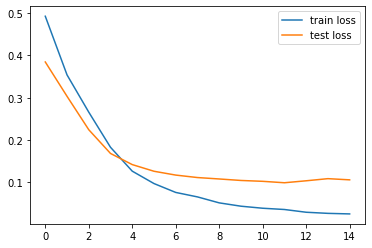

In [24]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [25]:
n_correct = 0.
n_total = 0.

for inputs, targets in train_gen():
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    predictions = (outputs > 0).float()

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total
n_correct = 0.
n_total = 0.

for inputs, targets in test_gen():
    targets = targets.view(-1, 1).float()

    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    predictions = (outputs > 0).float()

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9954, Test acc: 0.9755
